In [1]:
import pyabf 
import numpy as np
import re
import os
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
def parse_file_name(foldername_string): 
    f_dict=re.match(r"(?P<date>\d{8})-(?P<time>\d{6})_(?P<construct>\w.+)_CS_(?P<coverslip>\w+)_cell_(?P<cell>\d+)(?P<protocol>\w+)?",foldername_string)
    return f_dict.groupdict()

In [3]:
def base_line_check(abf):
    base_line = np.mean(abf.sweepY[int(50000*0.1):int(50000*0.3)])
    return base_line

In [4]:
def stimulation_timing_finder(abf):
    abf.setSweep(0,5)
    stim_on_yellow_index = np.where(abf.sweepY<4)[0][0]
    stim_off_yellow_index = np.max(np.where(abf.sweepY<4)[0])
    abf.setSweep(0,6)
    stim_on_cyan_index = np.where(abf.sweepY<4)[0][0]
    stim_off_cyan_index = np.max(np.where(abf.sweepY<4)[0])
    return stim_on_yellow_index,stim_off_yellow_index,stim_on_cyan_index,stim_off_cyan_index


In [5]:
def sweeps_runner_GtACR2(abf):
    cross_talk_mean_list = []
    excitation_mean_list = []
    for sweep in abf.sweepList:
        abf.setSweep(sweep,0)
        base_line = base_line_check(abf)
        if base_line<-400 or base_line>400:
            break
        abf.setSweep(sweep,0,baseline = [0.1,0.5])
        stim_on_yellow_index,stim_off_yellow_index,stim_on_cyan_index,stim_off_cyan_index = stimulation_timing_finder(abf)
        abf.setSweep(sweep,0,baseline = [0.1,0.5])
        cross_mean      = np.mean(abf.sweepY[stim_on_yellow_index:stim_off_yellow_index])
        excitation_mean = np.mean(abf.sweepY[stim_on_cyan_index:stim_off_cyan_index])
        cross_talk_mean_list.append(cross_mean)
        excitation_mean_list.append(excitation_mean)
    max_recording_cross      = np.max(cross_talk_mean_list)
    max_recording_excitation = np.max(excitation_mean_list)
    sweep0_peak = excitation_mean_list[0]
    sweep1_peak = excitation_mean_list[1]
    sweep2_peak = excitation_mean_list[2]
    sweep3_peak = excitation_mean_list[3]
    sweep4_peak = excitation_mean_list[4]
    sweep5_peak = excitation_mean_list[5]
    sweep0_peak_cross = cross_talk_mean_list[0]
    sweep1_peak_cross = cross_talk_mean_list[1]
    sweep2_peak_cross = cross_talk_mean_list[2]
    sweep3_peak_cross = cross_talk_mean_list[3]
    sweep4_peak_cross = cross_talk_mean_list[4]
    sweep5_peak_cross = cross_talk_mean_list[5]
    
    return max_recording_cross,max_recording_excitation,sweep0_peak,sweep1_peak,sweep2_peak,sweep3_peak,sweep4_peak,sweep5_peak,sweep0_peak_cross,sweep1_peak_cross,sweep2_peak_cross,sweep3_peak_cross,sweep4_peak_cross,sweep5_peak_cross

In [6]:
def sweeps_runner_vfChrimsonR(abf):
    cross_talk_mean_list = []
    excitation_mean_list = []
    for sweep in abf.sweepList:
        abf.setSweep(sweep,0)
        base_line = base_line_check(abf)
        if base_line<-300 or base_line>300:
            break
        abf.setSweep(sweep,0,baseline = [0.1,0.5])
        stim_on_yellow_index,stim_off_yellow_index,stim_on_cyan_index,stim_off_cyan_index = stimulation_timing_finder(abf)
        abf.setSweep(sweep,0,baseline = [0.1,0.5])
        cross_mean      = np.mean(abf.sweepY[stim_on_cyan_index:stim_off_cyan_index])
        excitation_mean = np.mean(abf.sweepY[stim_on_yellow_index:stim_off_yellow_index])
        cross_talk_mean_list.append(cross_mean)
        excitation_mean_list.append(excitation_mean)

    max_recording_cross      = np.min(cross_talk_mean_list)
    max_recording_excitation = np.min(excitation_mean_list)
    sweep0_peak = excitation_mean_list[0]
    sweep1_peak = excitation_mean_list[1]
    sweep2_peak = excitation_mean_list[2]
    sweep3_peak = excitation_mean_list[3]
    sweep4_peak = excitation_mean_list[4]
    sweep5_peak = excitation_mean_list[5]
    sweep0_peak_cross = cross_talk_mean_list[0]
    sweep1_peak_cross = cross_talk_mean_list[1]
    sweep2_peak_cross = cross_talk_mean_list[2]
    sweep3_peak_cross = cross_talk_mean_list[3]
    sweep4_peak_cross = cross_talk_mean_list[4]
    sweep5_peak_cross = cross_talk_mean_list[5]
    return max_recording_cross,max_recording_excitation,sweep0_peak_cross,sweep1_peak_cross,sweep2_peak_cross,sweep3_peak_cross,sweep4_peak_cross,sweep5_peak_cross,sweep0_peak,sweep1_peak,sweep2_peak,sweep3_peak,sweep4_peak,sweep5_peak,

In [7]:
df = pd.DataFrame(columns = ['Construct','Mean steady-state photo current','Mean peak cross','peak_sweep0','peak_sweep1','peak_sweep2','peak_sweep3','peak_sweep4','peak_sweep5','cross sweep0','cross sweep1','cross sweep2','cross sweep3','cross sweep4','cross sweep5'])

In [8]:
folder_path   = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\DATA_marc24"

In [9]:
counter = 0
for folder_names in os.listdir(folder_path):
    folder_path_inside = os.path.join(folder_path,folder_names+'\\EPHYS\\')
    for file_name in os.listdir(folder_path_inside):
        file_path_inside = os.path.join(folder_path_inside,file_name)
        counter            = counter+1
        abf                = pyabf.ABF(file_path_inside)
        folder_name_string = abf.abfFileComment
        try:
            file_name_parse= parse_file_name(folder_name_string)
        except:
            continue
        construct_name     = file_name_parse['construct']

        if len(folder_name_string)<10:
            continue
        if construct_name =='AAV223':
            try:
                max_recording_cross,max_recording_excitation,sweep0_peak,sweep1_peak,sweep2_peak,sweep3_peak,sweep4_peak,sweep5_peak,sweep0_peak_cross,sweep1_peak_cross,sweep2_peak_cross,sweep3_peak_cross,sweep4_peak_cross,sweep5_peak_cross = sweeps_runner_GtACR2(abf)
            except:
                continue
        else:
            try:
                max_recording_excitation,max_recording_cross,sweep0_peak,sweep1_peak,sweep2_peak,sweep3_peak,sweep4_peak,sweep5_peak,sweep0_peak_cross,sweep1_peak_cross,sweep2_peak_cross,sweep3_peak_cross,sweep4_peak_cross,sweep5_peak_cross = sweeps_runner_vfChrimsonR(abf)
            except:
                continue

        row_data = {'Construct':construct_name,'Mean steady-state photo current':max_recording_excitation,'Mean peak cross':max_recording_cross,'peak_sweep0':sweep0_peak,'peak_sweep1':sweep1_peak,'peak_sweep2':sweep2_peak,'peak_sweep3':sweep3_peak,'peak_sweep4':sweep4_peak,'peak_sweep5':sweep5_peak,'cross sweep0':sweep0_peak_cross,'cross sweep1':sweep1_peak_cross,'cross sweep2':sweep2_peak_cross,'cross sweep3':sweep3_peak_cross,'cross sweep4':sweep4_peak_cross,'cross sweep5':sweep5_peak_cross}
        df.loc[counter] = (row_data)

# Comments:
#### The recording of the GtACR2 construct were done while holding the cells at 0 mV
#### and with synaptic blockers (TTX,CNQX,APV)
#### LED units are between 1:4
#### in each sweep we are stimulationg the cells with 50ms yellow light pulse and then 50ms cyan light pulse. 
#### ND filter 63% 


In [10]:
path_for_plot = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\DATA_marc24\18.03.2024\EPHYS\2024_03_18_0018.abf"
abf = pyabf.ABF(path_for_plot)

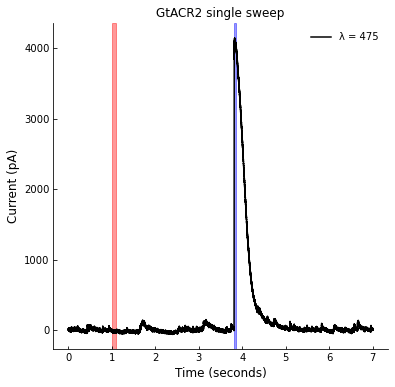

In [11]:
stim_on_yellow_index,stim_off_yellow_index,stim_on_cyan_index,stim_off_cyan_index = stimulation_timing_finder(abf)
abf.setSweep(5,0,baseline = [0.2,0.5])
plt.figure(figsize = [6,6])
plt.plot(abf.sweepX,abf.sweepY,label = 'λ = 475',color = 'k')
plt.xlabel('Time (seconds)' ,fontsize=12)
plt.ylabel('Current (pA)',fontsize=12)
plt.title('GtACR2 single sweep',fontsize=12)
plt.legend(frameon = False)
plt.axvspan(1,1.1, color='red', alpha=0.4)
plt.axvspan(3.8,3.85, color='blue', alpha=0.4)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

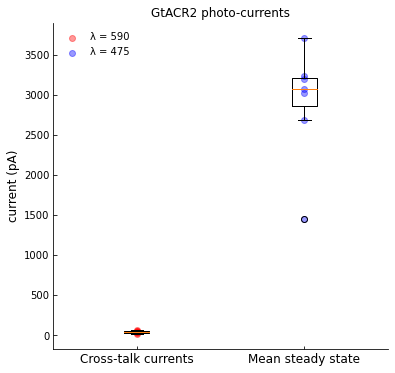

In [12]:
GtACR2_df = df[df['Construct']=='AAV223']
plt.figure(figsize = [6,6])
plt.scatter(np.ones(len(GtACR2_df)),GtACR2_df['Mean steady-state photo current'],color = 'red',alpha = 0.4,label = 'λ = 590')
plt.boxplot([GtACR2_df['Mean steady-state photo current'],GtACR2_df['Mean peak cross']])
plt.scatter(np.ones(len(GtACR2_df))*2,GtACR2_df['Mean peak cross'],color = 'blue',alpha = 0.4,label = 'λ = 475')
plt.title('GtACR2 photo-currents',fontsize=12)
plt.ylabel('current (pA)',fontsize=12)
plt.xticks([1,2],['Cross-talk currents','Mean steady state',],fontsize=12)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.show()


# Comments:
### The recordings of the two Chrimson constructs were done with yellow LED filter
### and synaptic blockers (TTX,CNQX,APV)
### the protocol for the Chrimson excitation is the the protocol as we use for the GtACR2 construct in the previous section. 

In [13]:
path_for_plot = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\DATA_marc24\18.03.2024\EPHYS\2024_03_18_0009.abf"
abf = pyabf.ABF(path_for_plot)
abf.setSweep(4,0,baseline = [0.2,0.5])

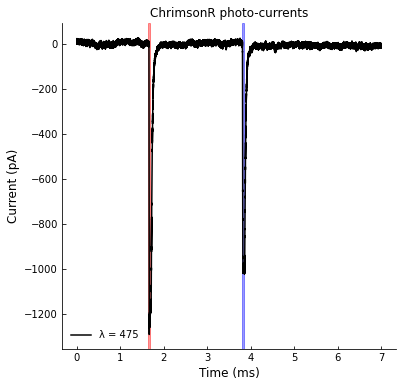

In [14]:
plt.figure(figsize = [6,6])
plt.plot(abf.sweepX,abf.sweepY,label = 'λ = 475', color = 'k')
plt.xlabel('Time (ms)',fontsize=12)
plt.ylabel('Current (pA)',fontsize=12)
plt.title('ChrimsonR photo-currents',fontsize=12)
plt.axvspan(3.8,3.85, color='blue', alpha=0.4)
plt.axvspan(1.63, 1.68, color='red', alpha=0.4)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.show()

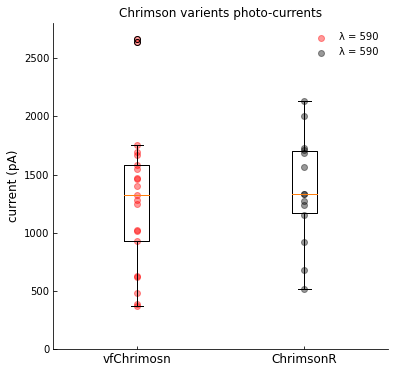

In [15]:
vfChrimson_df = df[df['Construct']=='D918']
ChrimosnR_df = df[df['Construct']=='D919']
plt.figure(figsize = [6,6])
plt.scatter(np.ones(len(vfChrimson_df)),np.abs(vfChrimson_df['Mean steady-state photo current']),color = 'red',alpha = 0.4,label = 'λ = 590')
plt.boxplot([np.abs(vfChrimson_df['Mean steady-state photo current']),np.abs(ChrimosnR_df['Mean steady-state photo current'])])
plt.scatter(np.ones(len(ChrimosnR_df))*2,np.abs(ChrimosnR_df['Mean steady-state photo current']),color = 'black',alpha = 0.4,label = 'λ = 590')
plt.title('Chrimson varients photo-currents',fontsize=12)
plt.ylabel('current (pA)',fontsize=12)
plt.xticks([1,2],['vfChrimosn','ChrimsonR'],fontsize=12)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.ylim([0,2800])
plt.show()

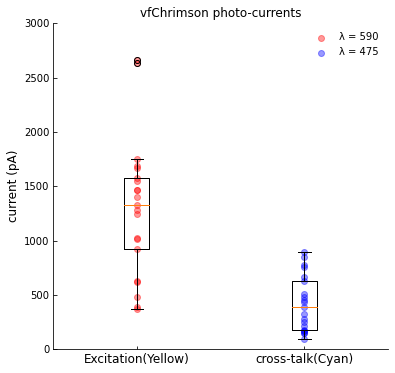

In [16]:
vfChrimson_df = df[df['Construct']=='D918']
ChrimsonR_df = df[df['Construct']=='D919']
plt.figure(figsize = [6,6])
plt.scatter(np.ones(len(vfChrimson_df)),np.abs(vfChrimson_df['Mean steady-state photo current']),color = 'red',alpha = 0.4,label = 'λ = 590')
plt.boxplot([np.abs(vfChrimson_df['Mean steady-state photo current']),np.abs(vfChrimson_df['Mean peak cross'])])
plt.scatter(np.ones(len(vfChrimson_df))*2,np.abs(vfChrimson_df['Mean peak cross']),color = 'blue',alpha = 0.4,label = 'λ = 475')
plt.title('vfChrimson photo-currents',fontsize=12)
plt.ylabel('current (pA)',fontsize=12)
plt.xticks([1,2],['Excitation(Yellow)','cross-talk(Cyan)'],fontsize=12)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.ylim([0,3000])
plt.show()

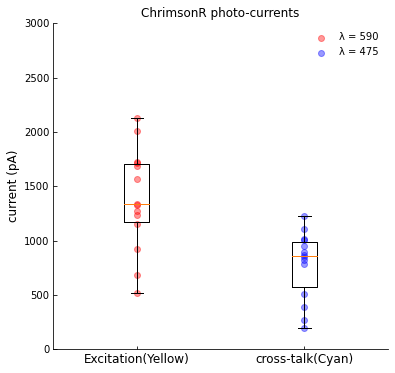

In [17]:
plt.figure(figsize = [6,6])
plt.scatter(np.ones(len(ChrimsonR_df)),np.abs(ChrimsonR_df['Mean steady-state photo current']),color = 'red',alpha = 0.4,label = 'λ = 590')
plt.boxplot([np.abs(ChrimsonR_df['Mean steady-state photo current']),np.abs(ChrimsonR_df['Mean peak cross'])])
plt.scatter(np.ones(len(ChrimsonR_df))*2,np.abs(ChrimsonR_df['Mean peak cross']),color = 'blue',alpha = 0.4,label = 'λ = 475')
plt.title('ChrimsonR photo-currents',fontsize=12)
plt.ylabel('current (pA)',fontsize=12)
plt.xticks([1,2],['Excitation(Yellow)','cross-talk(Cyan)'],fontsize=12)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.ylim([0,3000])
plt.show()

In [18]:
vfChrimson_df = df[df['Construct']=='D918']
ChrimosnR_df = df[df['Construct']=='D919']
GtACR2_df = df[df['Construct']=='AAV223']
Control = df[df['Construct']=='Add12']


In [19]:
vf_sweep0_mean = np.mean(vfChrimson_df['peak_sweep0'])
vf_sweep1_mean = np.mean(vfChrimson_df['peak_sweep1'])
vf_sweep2_mean = np.mean(vfChrimson_df['peak_sweep2'])
vf_sweep3_mean = np.mean(vfChrimson_df['peak_sweep3'])
vf_sweep4_mean = np.mean(vfChrimson_df['peak_sweep4'])
vf_sweep5_mean = np.mean(vfChrimson_df['peak_sweep5'])
vf_sweep0_cross_mean = np.mean(vfChrimson_df['cross sweep0'])
vf_sweep1_cross_mean = np.mean(vfChrimson_df['cross sweep1'])
vf_sweep2_cross_mean = np.mean(vfChrimson_df['cross sweep2'])
vf_sweep3_cross_mean = np.mean(vfChrimson_df['cross sweep3'])
vf_sweep4_cross_mean = np.mean(vfChrimson_df['cross sweep4'])
vf_sweep5_cross_mean = np.mean(vfChrimson_df['cross sweep5'])
vf_peak_sweeps_list = [vf_sweep0_mean,vf_sweep1_mean,vf_sweep2_mean,vf_sweep3_mean,vf_sweep4_mean,vf_sweep5_mean]
vf_cross_sweeps_list = [vf_sweep0_cross_mean,vf_sweep1_cross_mean,vf_sweep2_cross_mean,vf_sweep3_cross_mean,vf_sweep4_cross_mean,vf_sweep5_cross_mean]

In [20]:
ChR_sweep0_mean = np.mean(ChrimsonR_df['peak_sweep0'])
ChR_sweep1_mean = np.mean(ChrimsonR_df['peak_sweep1'])
ChR_sweep2_mean = np.mean(ChrimsonR_df['peak_sweep2'])
ChR_sweep3_mean = np.mean(ChrimsonR_df['peak_sweep3'])
ChR_sweep4_mean = np.mean(ChrimsonR_df['peak_sweep4'])
ChR_sweep5_mean = np.mean(ChrimsonR_df['peak_sweep5'])

ChR_sweep0_cross_mean = np.mean(ChrimosnR_df['cross sweep0'])
ChR_sweep1_cross_mean = np.mean(ChrimosnR_df['cross sweep1'])
ChR_sweep2_cross_mean = np.mean(ChrimosnR_df['cross sweep2'])
ChR_sweep3_cross_mean = np.mean(ChrimosnR_df['cross sweep3'])
ChR_sweep4_cross_mean = np.mean(ChrimosnR_df['cross sweep4'])
ChR_sweep5_cross_mean = np.mean(ChrimosnR_df['cross sweep5'])

ChR_peak_sweeps_list = [ChR_sweep0_mean,ChR_sweep1_mean,ChR_sweep2_mean,ChR_sweep3_mean,ChR_sweep4_mean,ChR_sweep5_mean]
ChR_cross_sweeps_list = [ChR_sweep0_cross_mean,ChR_sweep1_cross_mean,ChR_sweep2_cross_mean,ChR_sweep3_cross_mean,ChR_sweep4_cross_mean,ChR_sweep5_cross_mean]

In [21]:
GtACR2_df_cross_std     = GtACR2_df[['peak_sweep0','peak_sweep1','peak_sweep2','peak_sweep3','peak_sweep4','peak_sweep5']].std()
GtACR2_df_peak_std      = GtACR2_df[['cross sweep0','cross sweep1','cross sweep2','cross sweep3','cross sweep4','cross sweep5']].std()
chrimsonR_df_peak_std   = ChrimsonR_df[['peak_sweep0','peak_sweep1','peak_sweep2','peak_sweep3','peak_sweep4','peak_sweep5']].std()
ChrimsonR_df_cross_std  = ChrimsonR_df[['cross sweep0','cross sweep1','cross sweep2','cross sweep3','cross sweep4','cross sweep5']].std()
vfChrimson_df_peak_std  = vfChrimson_df[['peak_sweep0','peak_sweep1','peak_sweep2','peak_sweep3','peak_sweep4','peak_sweep5']].std()
vfChrimson_df_cross_std = vfChrimson_df[['cross sweep0','cross sweep1','cross sweep2','cross sweep3','cross sweep4','cross sweep5']].std()

In [22]:
GtACR2_sweep0_mean = np.mean(GtACR2_df['peak_sweep0'])
GtACR2_sweep1_mean = np.mean(GtACR2_df['peak_sweep1'])
GtACR2_sweep2_mean = np.mean(GtACR2_df['peak_sweep2'])
GtACR2_sweep3_mean = np.mean(GtACR2_df['peak_sweep3'])
GtACR2_sweep4_mean = np.mean(GtACR2_df['peak_sweep4'])
GtACR2_sweep5_mean = np.mean(GtACR2_df['peak_sweep5'])

GtACR2_sweep0_cross_mean = np.mean(GtACR2_df['cross sweep0'])
GtACR2_sweep1_cross_mean = np.mean(GtACR2_df['cross sweep1'])
GtACR2_sweep2_cross_mean = np.mean(GtACR2_df['cross sweep2'])
GtACR2_sweep3_cross_mean = np.mean(GtACR2_df['cross sweep3'])
GtACR2_sweep4_cross_mean = np.mean(GtACR2_df['cross sweep4'])
GtACR2_sweep5_cross_mean = np.mean(GtACR2_df['cross sweep5'])

GtACR2_cross_sweeps_list = [GtACR2_sweep0_cross_mean,GtACR2_sweep1_cross_mean,GtACR2_sweep2_cross_mean,GtACR2_sweep3_cross_mean,GtACR2_sweep4_cross_mean,GtACR2_sweep5_cross_mean]
GtACR2_peak_sweeps_list = [GtACR2_sweep0_mean,GtACR2_sweep1_mean,GtACR2_sweep2_mean,GtACR2_sweep3_mean,GtACR2_sweep4_mean,GtACR2_sweep5_mean]

In [23]:
peak_yellow = [579.833984375,
 2929.6875,
 5920.41015625,
 8422.8515625,
 10864.2578125,
 13153.076171875]
peak_yellow = np.array(peak_yellow)

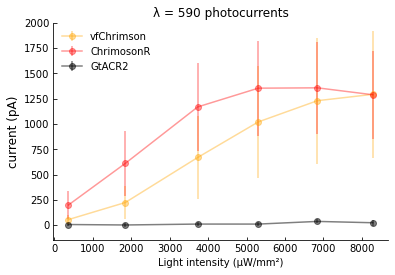

In [24]:
plt.errorbar(peak_yellow*0.63,np.abs(vf_peak_sweeps_list),vfChrimson_df_peak_std,marker = 'o',color='#FFA500',alpha = 0.4,label = 'vfChrimson')
plt.errorbar(peak_yellow*0.63,np.abs(ChR_peak_sweeps_list),chrimsonR_df_peak_std,marker = 'o',color = 'red',alpha = 0.4,label = 'ChrimosonR')
plt.errorbar(peak_yellow*0.63,np.abs(GtACR2_peak_sweeps_list),GtACR2_df_cross_std,marker = 'o',color = 'black',alpha = 0.5,label = 'GtACR2')

plt.title('λ = 590 photocurrents',fontsize=12)
plt.ylabel('current (pA)',fontsize=12)
plt.xlabel('Light intensity (μW/mm\u00b2)')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False,loc = 'upper left')
plt.ylim([-150,2000])
plt.show()

In [25]:
peak_cyan = [366.2109375,
 1007.080078125,
 1892.08984375,
 2441.40625,
 2838.134765625,
 3448.486328125]
peak_cyan = np.array(peak_cyan)

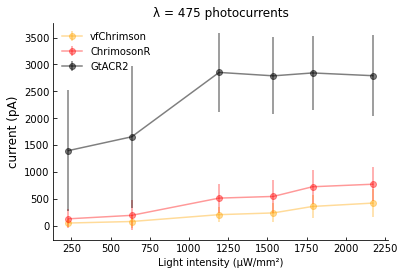

In [26]:
plt.errorbar(peak_cyan*0.63,np.abs(vf_cross_sweeps_list),vfChrimson_df_cross_std,marker = 'o',color='#FFA500',alpha = 0.4,label = 'vfChrimson')
plt.errorbar(peak_cyan*0.63,np.abs(ChR_cross_sweeps_list),ChrimsonR_df_cross_std,marker = 'o',color = 'red',alpha = 0.4,label = 'ChrimosonR')
plt.errorbar(peak_cyan*0.63,np.abs(GtACR2_cross_sweeps_list),GtACR2_df_peak_std,marker = 'o',color = 'black',alpha = 0.5,label = 'GtACR2')

plt.title('λ = 475 photocurrents',fontsize=12)
plt.ylabel('current (pA)',fontsize=12)
plt.xlabel('Light intensity (μW/mm\u00b2)')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.show()

In [27]:
abf = pyabf.ABF(r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\DATA_marc24\18.03.2024\EPHYS\2024_03_18_0001.abf")

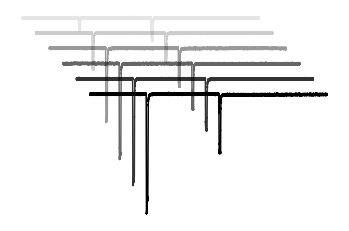

In [28]:
abf.setSweep(0,0)
plt.plot(abf.sweepX,abf.sweepY,color = 'black',alpha = 0.1)
abf.setSweep(1,0)
plt.plot(abf.sweepX+0.4,abf.sweepY-250,color = 'black',alpha = 0.2)
abf.setSweep(2,0)
plt.plot(abf.sweepX+0.8,abf.sweepY-500,color = 'black',alpha = 0.4)
abf.setSweep(3,0)
plt.plot(abf.sweepX+1.2,abf.sweepY-750,color = 'black',alpha = 0.6)
abf.setSweep(4,0)
plt.plot(abf.sweepX+1.6,abf.sweepY-1000,color = 'black',alpha = 0.8)
abf.setSweep(5,0)
plt.plot(abf.sweepX+2,abf.sweepY-1250,color = 'black')
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

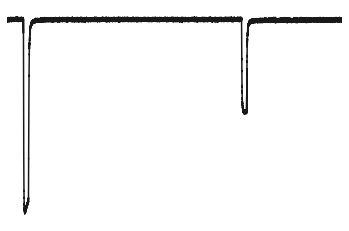

In [29]:
abf.setSweep(3,0)
plt.plot(abf.sweepX,abf.sweepY,color = 'black',alpha = 0.9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.xlim(1.5,4.8)
plt.show()

### Section 2: Spiking Chrimson cultures. 

Examples of a typical trace

In [30]:
spiking_path = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\21.03.2024\EPHYS\D918\2024_03_21_0018.abf"

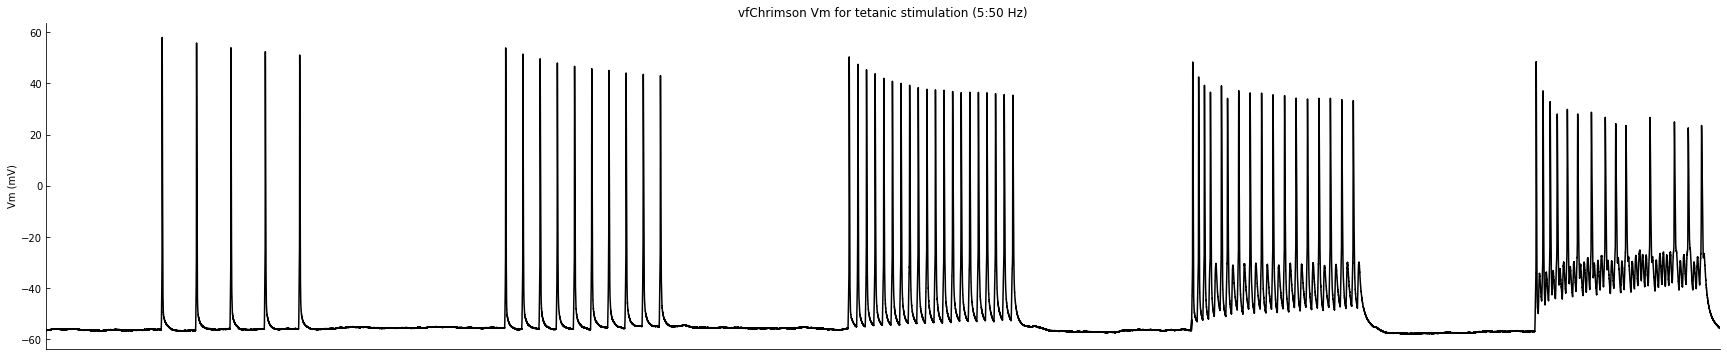

In [31]:
abf = pyabf.ABF(spiking_path)
abf.setSweep(0,0)
plt.figure(figsize = [30,6])
plt.plot(abf.sweepX*2,abf.sweepY,color = 'black')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([])
plt.ylabel('Vm (mV)')
plt.title('vfChrimson Vm for tetanic stimulation (5:50 Hz)')
plt.xlim(1,20.5)
plt.show()

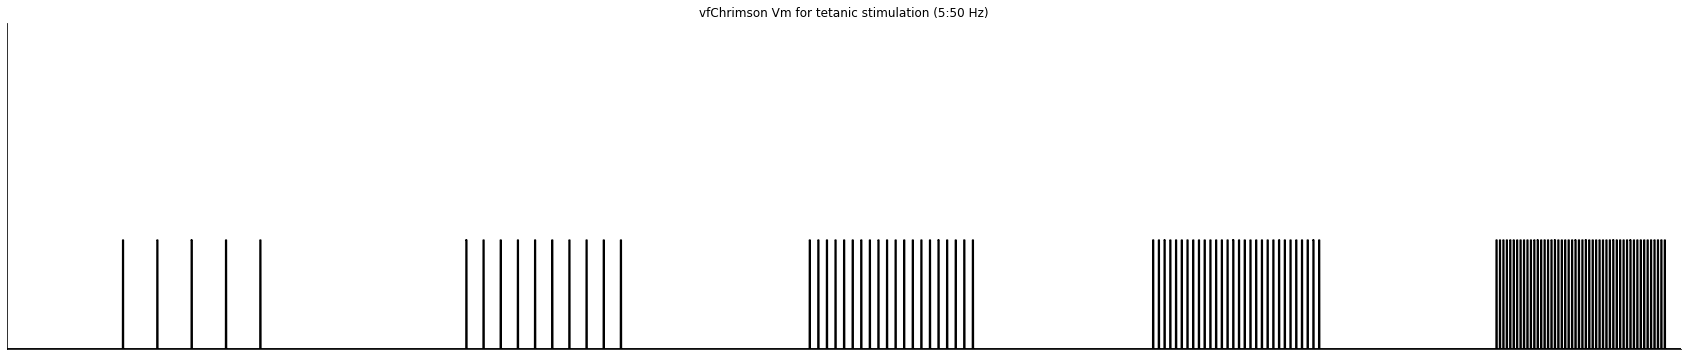

In [32]:
abf = pyabf.ABF(spiking_path)
abf.setSweep(0,2)
plt.figure(figsize=[30,6])
plt.plot(abf.sweepX*2,abf.sweepY,color = 'black')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.ylim(5,-10)
plt.xlim(1,20.5)
plt.title('vfChrimson Vm for tetanic stimulation (5:50 Hz)')
plt.show()

In [33]:
def spike_detector(threshold,folder_path):
    df_name = pd.DataFrame(columns = ['5Hz','10Hz','20Hz','29Hz','50Hz'])
    counter = 0
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path,file)
        abf = pyabf.ABF(file_path)
        abf.setSweep(0,0)
        abf5Hz  = abf.sweepY[50000:110000]
        abf10Hz = abf.sweepY[110000:250000]
        abf20Hz = abf.sweepY[250000:350000]
        abf29Hz = abf.sweepY[350000:450000]
        abf50Hz = abf.sweepY[450000:550000]
        segments = [abf5Hz,abf10Hz,abf20Hz,abf29Hz,abf50Hz]
        spikes_in_file = []
        for segment in segments:
            num_spikes_inXHz = 0
            start_slide = 0
            end_slide = 50
            while end_slide<len(segment):
                sliding_segment = segment[start_slide:end_slide]
                detect_spike = np.where(sliding_segment>threshold)
                if any(detect_spike[0]):
                    num_spikes_inXHz +=1
                    start_slide += 200
                    end_slide += 200
                else: 
                    start_slide += 50
                    end_slide += 50
            spikes_in_file.append(num_spikes_inXHz)
        counter+=1
        row_data = {'5Hz':spikes_in_file[0]/5,'10Hz':spikes_in_file[1]/10,'20Hz':spikes_in_file[2]/20,'29Hz':spikes_in_file[3]/29,'50Hz':spikes_in_file[4]/50}
        df_name.loc[counter] = row_data
    return df_name


In [34]:
spiking_path = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\21.03.2024\EPHYS\D918"
df_918  = spike_detector(20,spiking_path)
spiking_path = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\21.03.2024\EPHYS\D919"
df_919  = spike_detector(20,spiking_path)

In [35]:
vfchrimson_spike_p  = np.mean(df_918)
vfchrimson_spike_p_std = np.std(df_918)
chrimson_r_spike_p  = np.mean(df_919)
chrimson_r_spike_p_std  = np.std(df_919)

c:\Users\omeri\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\omeri\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


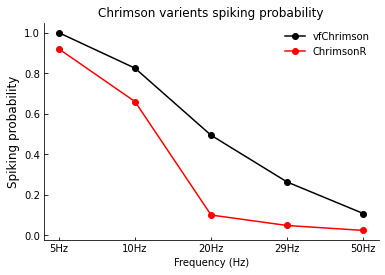

In [36]:
plt.plot(vfchrimson_spike_p,marker ='o',color = 'black',label = 'vfChrimson')
plt.plot(chrimson_r_spike_p,marker = 'o',color = 'red',label = 'ChrimsonR')
plt.title('Chrimson varients spiking probability',fontsize=12)
plt.ylabel('Spiking probability',fontsize=12)
plt.xlabel('Frequency (Hz)')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.show()

## Section 3: showing the effect of cyan light on over current injection. 
### I'm using Gabazine in order to block gabaA receptors.  
### 4 LED units of cyan light


In [37]:
file_path_gtacr2 = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\DATA_marc24\28.03.2024\EPHYS\2024_03_28_0008.abf"

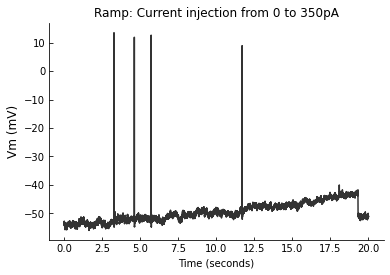

In [38]:
abf = pyabf.ABF(file_path_gtacr2)
abf.setSweep(0,0)
plt.plot(abf.sweepX,abf.sweepY,color = 'k',alpha = 0.8)
plt.title('Ramp: Current injection from 0 to 350pA',fontsize=12)
plt.ylabel('Vm (mV)',fontsize=12)
plt.xlabel('Time (seconds)')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [39]:
file_path_gtacr2 = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\DATA_marc24\28.03.2024\EPHYS\2024_03_28_0004.abf"

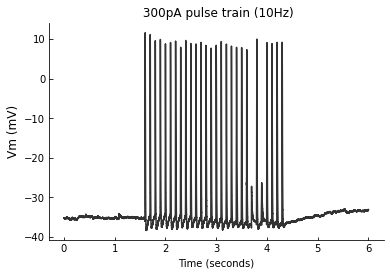

In [40]:
abf = pyabf.ABF(file_path_gtacr2)
abf.setSweep(0,1)
plt.plot(abf.sweepX,abf.sweepY,color = 'k',alpha = 0.8)
plt.title(' 300pA pulse train (10Hz)',fontsize=12)
plt.ylabel('Vm (mV)',fontsize=12)
plt.xlabel('Time (seconds)')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [41]:
file_path_gtacr2 = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\M.Sc\Project1\Ephys recordings\DATA_marc24\28.03.2024\EPHYS\2024_03_28_0005.abf"

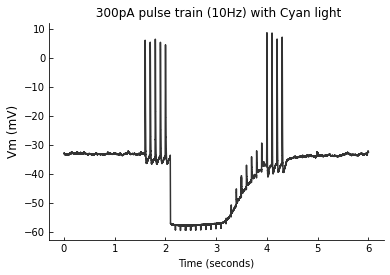

In [42]:
abf = pyabf.ABF(file_path_gtacr2)
abf.setSweep(0,1)
plt.plot(abf.sweepX,abf.sweepY,color = 'k',alpha = 0.8)
plt.title(' 300pA pulse train (10Hz) with Cyan light',fontsize=12)
plt.ylabel('Vm (mV)',fontsize=12)
plt.xlabel('Time (seconds)')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()